# World Data League 2022

## 🎯 Challenge
*Predict Waste Production for its Reduction*


## 👥 Authors
* Sourabh Hujare
* Nikhil Kulkarni
* Ronney Mathews
* Luckshan Sivakumar

### Data Cleaning

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px

In [5]:
df = pd.read_csv('C:/Users/nikhil.kulkarni/WDL/waste_collection.csv')

In [6]:
df.head()

Report Date                  Load Type               Load Time  Load Weight  \
0  12/08/2020                       BULK  12/08/2020 03:02:00 PM       5220.0   
1  12/08/2020  RECYCLING - SINGLE STREAM  12/08/2020 10:00:00 AM      11140.0   
2  12/03/2020  RECYCLING - SINGLE STREAM  12/03/2020 10:34:00 AM      10060.0   
3  12/07/2020                   SWEEPING  12/07/2020 10:15:00 AM       7100.0   
4  12/07/2020  RECYCLING - SINGLE STREAM  12/07/2020 04:00:00 PM      12000.0   

         Dropoff Site                 Route Type Route Number  Load ID  
0        TDS LANDFILL                       BULK         BU13   899097  
1           TDS - MRF  RECYCLING - SINGLE STREAM       RTAU53   899078  
2  BALCONES RECYCLING  RECYCLING - SINGLE STREAM       RHBU10   899082  
3        TDS LANDFILL          SWEEPER DUMPSITES        DSS04   899030  
4           TDS - MRF  RECYCLING - SINGLE STREAM       RMAU53   899048

In [7]:
print("Shape of dataframe is {}".format(df.shape))

Shape of dataframe is (740873, 8)


In [8]:
#Convert date related columns from string to datetime
df["Load Time"]= pd.to_datetime(df["Load Time"])
df["Load Year"] = pd.to_numeric(df["Load Time"].dt.strftime("%Y"))
df["Load Month"] = pd.to_numeric(df["Load Time"].dt.strftime("%m"))

Checking the frequency of different load types

In [9]:
df["Load Type"].value_counts()

GARBAGE COLLECTIONS            258433
RECYCLING - SINGLE STREAM      147652
SWEEPING                        88563
YARD TRIMMING                   69571
BULK                            40120
BRUSH                           39164
RECYCLING - PAPER               32162
RECYCLING - COMINGLE            31125
ORGANICS                        17721
DEAD ANIMAL                      6862
TIRES                            3233
MIXED LITTER                     2177
LITTER                           1578
MULCH                            1344
RECYCLED METAL                   1049
BAGGED LITTER                      43
RECYCLING - PLASTIC BAGS           40
YARD TRIMMING - X-MAS TREES        17
MATTRESS                            9
CONTAMINATED RECYCLING              8
CONTAMINATED ORGANICS               1
CONTAMINATED YARD TRIMMINGS         1
Name: Load Type, dtype: int64

Any Load types having occurrences less than 7000 could be dropped considering the timeframe of the data (20 years). Therefore if a certain `Load Type` occurrs less that 7000 (approx 20 years) times then it could be dropped

In [10]:
df_filtered = df.groupby("Load Type").filter(lambda x: len(x) > 7000)
print("Number of data points after filtering are {}".format(len(df_filtered)))

Number of data points after filtering are 724511


Checking the number of datapoints available for every year

In [11]:
df_filtered["Load Year"].value_counts()

2008    49608
2007    48654
2006    47616
2020    45635
2005    44855
2019    43741
2018    42314
2017    41918
2015    41085
2016    41080
2009    40791
2013    40571
2014    40440
2010    40421
2011    39943
2012    39524
2021    25592
2004    10718
2001        4
2000        1
Name: Load Year, dtype: int64

Checking the yearly Load Weight Trend

In [12]:
df_yearly = df_filtered.groupby("Load Year")["Load Weight"].sum().reset_index()
fig = px.bar(df_yearly, x = "Load Year", y = "Load Weight",title = 'Total Load Weight per Year')
fig.show()

In general, as expected we see an increasing trend of Load weight collected over years but 2004 and 2021 seem odd, so investigating further for these years.

In [13]:
df_monthly = df_filtered[df_filtered["Load Year"]==2004].groupby("Load Month")["Load Weight"].sum().reset_index()
fig = px.bar(df_monthly, x = "Load Month", y = "Load Weight", title = 'Total Load weight per Month for 2004')
fig.show()

In [14]:
df_monthly = df_filtered[df_filtered["Load Year"]==2021].groupby("Load Month")["Load Weight"].sum().reset_index()
fig = px.bar(df_monthly, x = "Load Month", y = "Load Weight", title = 'Total Load weight per Month for 2021')
fig.show()

The data can now be fitered from 2005 to 2020 since 2004 & 2021 have no data for some months and is unreliable for forecasting purposes.

In [15]:
df_filtered = df_filtered[(df_filtered['Load Year']>=2005) & (df_filtered['Load Year']<=2020)]

Check for negative and zero `Load Weight` values and removing them

In [16]:
print(len(df_filtered[df_filtered["Load Weight"]<0]))
df_filtered = df_filtered[df_filtered["Load Weight"]>0]

1


Considering 20 Tonnes (44000 lbs) as the maximum cap. of a typical garbage truck, removing the points with `Load Weight` above this cap.

In [17]:
print(len(df_filtered[df_filtered["Load Weight"]>44000]))
df_filtered = df_filtered[df_filtered["Load Weight"]<=44000]

84


An interquartile range based outlier detection with factor 3 is done for sanity checks. However, as the trucks have already been filtered on their load weights, this becomes redundant.

In [18]:
def DetectOutliers(x, outlierConstant):
   a = np.array(x)
   upper_quartile = np.percentile(a, 75)
   lower_quartile = np.percentile(a, 25)
   IQR = (upper_quartile - lower_quartile) * outlierConstant
   quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
   resultList = []
   for y in a.tolist():
      if not ((y >= quartileSet[0]) and (y <= quartileSet[1])):
        resultList.append(y)
      return resultList,quartileSet
    

In [19]:
resultList,quartileSet=DetectOutliers(df_filtered["Load Weight"],3)
resultList,quartileSet

([], (-26060.0, 48840.0))

Check for missing values

In [20]:
print(df_filtered["Load Weight"].isna().sum())
print(df_filtered["Load Time"].isna().sum())

0
0


In [21]:
print("Number of data points after cleaning are {}".format(len(df_filtered)))

Number of data points after cleaning are 617943


In [22]:
df_filtered.to_csv('wdl_clean.csv')

### EDA

Doing EDA using Tableau on the clean data we get from above process. We present a few graphs here.

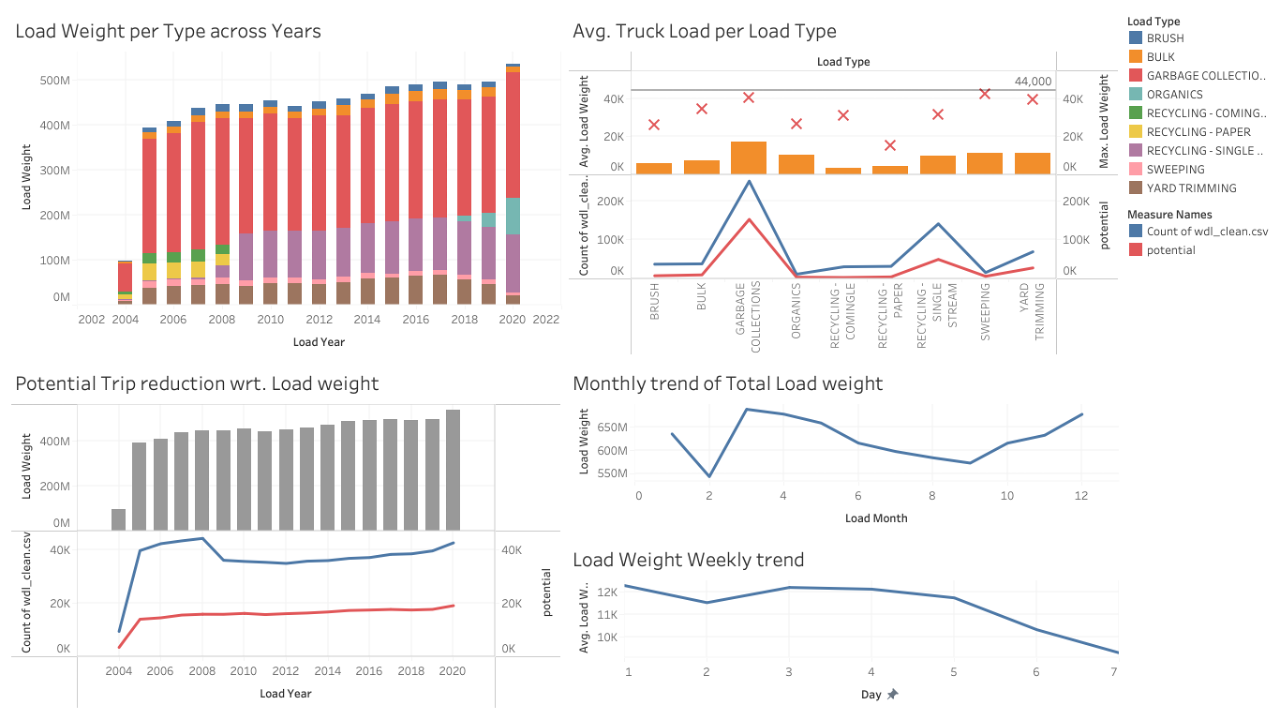

#### `Load Weight per Type across years`:
- This plot shows that Garbage collection consitutes the highest volume of generated waste and the overall trend is an increasing one

#### `Avg Load per Load Type` 
- The bar plot shows the average load weight for different load types. The red crosses show the maximum load weight for that type. It is assumed that an average waste collection truck has a max cap. of 44k lbs. The blue line in the line plot shows the average number of trips made for a given load type.
- However it is observed that not every trip is optimal in the context of optimal truck load (Assumed to be 80% of max. cap.) utilization. In case this optimality is achieved, which is shown by the red line in the plot, the gap between the red and the blue line then shows the  optimization potential per Load Type for the number of trips.

#### `Potential Trip reduction wrt. Load weight`
- This plot shows the optimization potential obtained by main utilizing full truck cap. and reducing the number of trips, across all years

#### `Monthly Trend of Total Load weight`
- The trend shows a peak in March which can be attributed to the SXSW festival which happens in mid March. This led us to investigate the other peaks and attribute them to other events that occur in Austin on a yearly basis.

#### `Load Weight weekly trend`
- The trend shows high volumes on weekdays, and a dip on the weekends.

### Forecasting Model
We use the open-source package "Prophet" for forecasting.

In [23]:
import fbprophet

In [24]:
# Formatting df to fit Prophet model needs.
df_prophet = df_filtered.rename(columns = {'Load Time':'ds', 'Load Weight' : 'y'})

Summing Load weight per week to do a top-level forecast as that has higher signal-to-noise ratio and is thus easier to forecast.

In [25]:
df_week = df_prophet[['ds','y']].groupby([pd.Grouper(key='ds', freq='W')])['y'].sum().reset_index().sort_values('ds')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


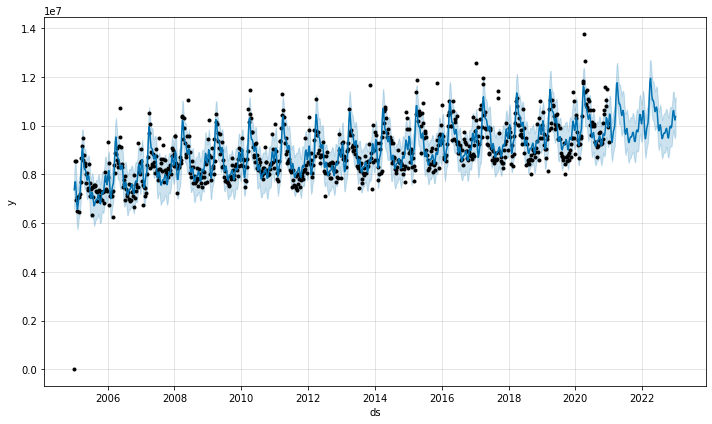

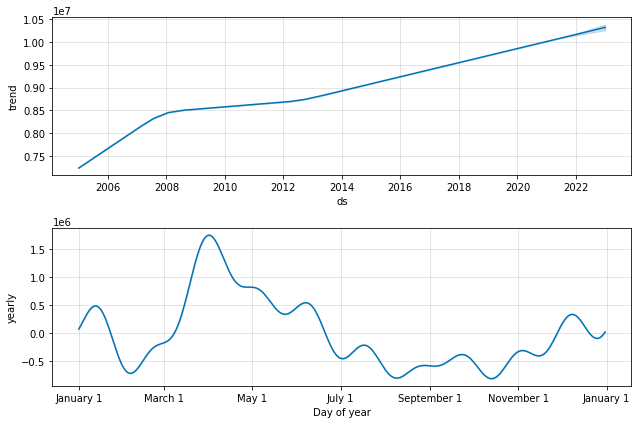

In [26]:
Prophet = fbprophet.Prophet
m = Prophet()
m.fit(df_week)

future = m.make_future_dataframe(periods=104, freq='W')

fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

In the first plot, the black dots are the actual values and the blue line a curve fitted by Prophet to the data and which forecasts into future as well.

In the second plot we see a neat increasing trend as expected

We see unusal peaks in the end of March. On some investigation we find that this can be attributed to the famous SXSW event. Lets check for correlation between other such events using Prophet Model's Additional regressor feature.

In [27]:
#Defining approximate event weeks using the following function and using Events data from a website (Mentioned in References section) 
def sxsw(ds):
    date = pd.to_datetime(ds)
    if (date.week >= 9 and date.week <= 12):
        return 1
    else:
        return 0
def aff(ds):
    date = pd.to_datetime(ds)
    if (date.week == 43):
        return 1
    else:
        return 0
def aclmf(ds):
    date = pd.to_datetime(ds)
    if (date.week ==41):
        return 1
    else:
        return 0
def ahsf(ds):
    date = pd.to_datetime(ds)
    if (date.week >= 31 and date.week <= 34):
        return 1
    else:
        return 0
def foodwine(ds):
    date = pd.to_datetime(ds)
    if (date.week >= 14 and date.week <= 17):
        return 1
    else:
        return 0
def psf(ds):
    date = pd.to_datetime(ds)
    if ((date.week >= 17 and date.week <= 18) or (date.week >= 39 and date.week <= 40)):
        return 1
    else:
        return 0
def cf(ds):
    date = pd.to_datetime(ds)
    if (date.week >= 51 and date.week <= 52):
        return 1
    else:
        return 0
def kf(ds):
    date = pd.to_datetime(ds)
    if (date.week >= 13 and date.week <= 14):
        return 1
    else:
        return 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


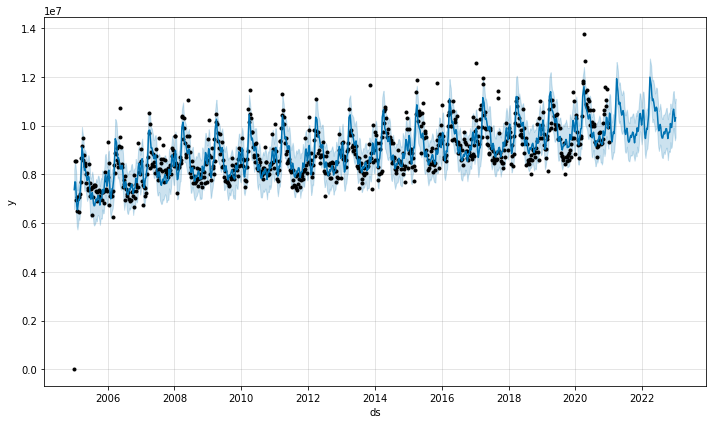

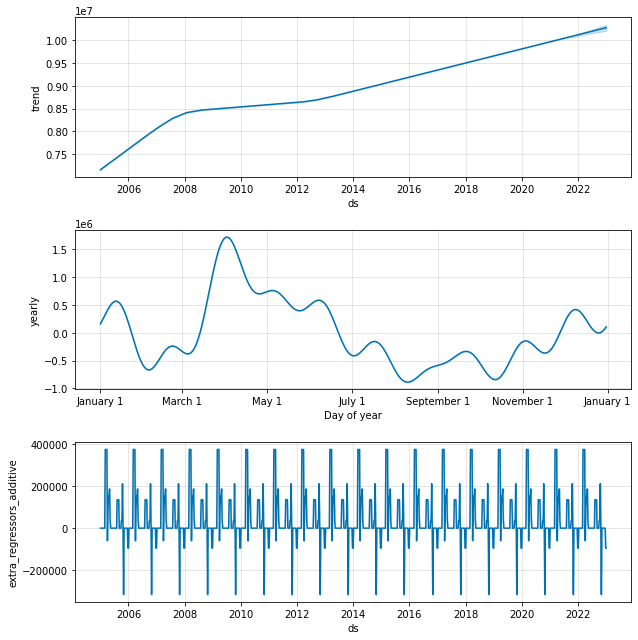

In [28]:
df_week['sxsw'] = df_week['ds'].apply(sxsw)
df_week['aff'] = df_week['ds'].apply(aff)
df_week['aclmf'] = df_week['ds'].apply(aclmf)
df_week['ahsf'] = df_week['ds'].apply(ahsf)
df_week['foodwine'] = df_week['ds'].apply(foodwine)
df_week['psf'] = df_week['ds'].apply(psf)
df_week['cf'] = df_week['ds'].apply(cf)
df_week['kf'] = df_week['ds'].apply(kf)

m = Prophet()
m.add_regressor('sxsw')
m.add_regressor('aff')
m.add_regressor('aclmf')
m.add_regressor('ahsf')
m.add_regressor('foodwine')
m.add_regressor('psf')
m.add_regressor('cf')
m.add_regressor('kf')

m.fit(df_week)

future['sxsw'] = future['ds'].apply(sxsw)
future['aff'] = future['ds'].apply(aff)
future['aclmf'] = future['ds'].apply(aclmf)
future['ahsf'] = future['ds'].apply(ahsf)
future['foodwine'] = future['ds'].apply(foodwine)
future['psf'] = future['ds'].apply(psf)
future['cf'] = future['ds'].apply(cf)
future['kf'] = future['ds'].apply(kf)

forecast = m.predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

Lets plot the effect of the additional regressors on the forecast

In [29]:
from fbprophet.utilities import regressor_coefficients
regressor_df = regressor_coefficients(m)

In [30]:
fig = px.bar(regressor_df, x = "regressor", y = "coef")
fig.show()

From the above graph we see that our assumptions regarding the SXSW event is validated. Also we see that some other events have a postive effect and can explain the other peaks we see in the yearly trends.

Lets check the accuracy of our Forecasting model by plotting MAPE (Mean Average Percentage Error) as suggested in the Prophet documentation.

In [31]:
from fbprophet.diagnostics import cross_validation

In [32]:
df_cv = cross_validation(m, initial='1000 days', period='365 days', horizon = '730 days')

INFO:fbprophet:Making 12 forecasts with cutoffs between 2008-01-07 00:00:00 and 2019-01-04 00:00:00


In [33]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

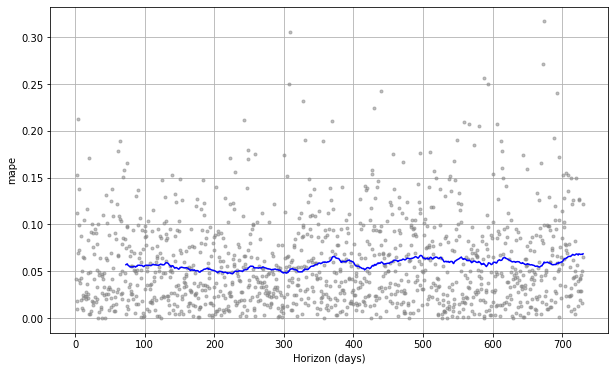

In [34]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions 3-4 months into the future, and that errors increase up to around 7-8% for predictions that are 2 years out. Therefore we have a pretty decent forecasting model.

Lets now forecast load weight for each Load type and have a look at individual trends of different load types.

In [35]:
df_all = pd.DataFrame()
for typ in df_prophet['Load Type'].unique():
  df_load_type = df_prophet[df_prophet['Load Type'] == typ][['ds','y']].groupby([pd.Grouper(key='ds', freq='W')])['y'].sum().reset_index().sort_values('ds')
  df_load_type['sxsw'] = df_load_type['ds'].apply(sxsw)
  df_load_type['aff'] = df_load_type['ds'].apply(aff)
  df_load_type['aclmf'] = df_load_type['ds'].apply(aclmf)
  df_load_type['ahsf'] = df_load_type['ds'].apply(ahsf)
  df_load_type['foodwine'] = df_load_type['ds'].apply(foodwine)
  df_load_type['psf'] = df_load_type['ds'].apply(psf)
  df_load_type['cf'] = df_load_type['ds'].apply(cf)
  df_load_type['kf'] = df_load_type['ds'].apply(kf)

  m_type = Prophet()
  m_type.add_regressor('sxsw')
  m_type.add_regressor('aff')
  m_type.add_regressor('aclmf')
  m_type.add_regressor('ahsf')
  m_type.add_regressor('foodwine')
  m_type.add_regressor('psf')
  m_type.add_regressor('cf')
  m_type.add_regressor('kf')

  m_type.fit(df_load_type)

  future = m_type.make_future_dataframe(periods=104, freq='W')

  future['sxsw'] = future['ds'].apply(sxsw)
  future['aff'] = future['ds'].apply(aff)
  future['aclmf'] = future['ds'].apply(aclmf)
  future['ahsf'] = future['ds'].apply(ahsf)
  future['foodwine'] = future['ds'].apply(foodwine)
  future['psf'] = future['ds'].apply(psf)
  future['cf'] = future['ds'].apply(cf)
  future['kf'] = future['ds'].apply(kf)

  forecast = m_type.predict(future)
  forecast_type =  forecast[forecast.ds >= '2022-01-01'][['ds', 'trend', 'yearly','yhat']]
  forecast_type['type'] = typ
  df_all = df_all.append(forecast_type)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [36]:
df_all.to_csv('forecast_load_type.csv')

Using Tableau we plot the forecast of each load type for the year 2022 to get more insights.

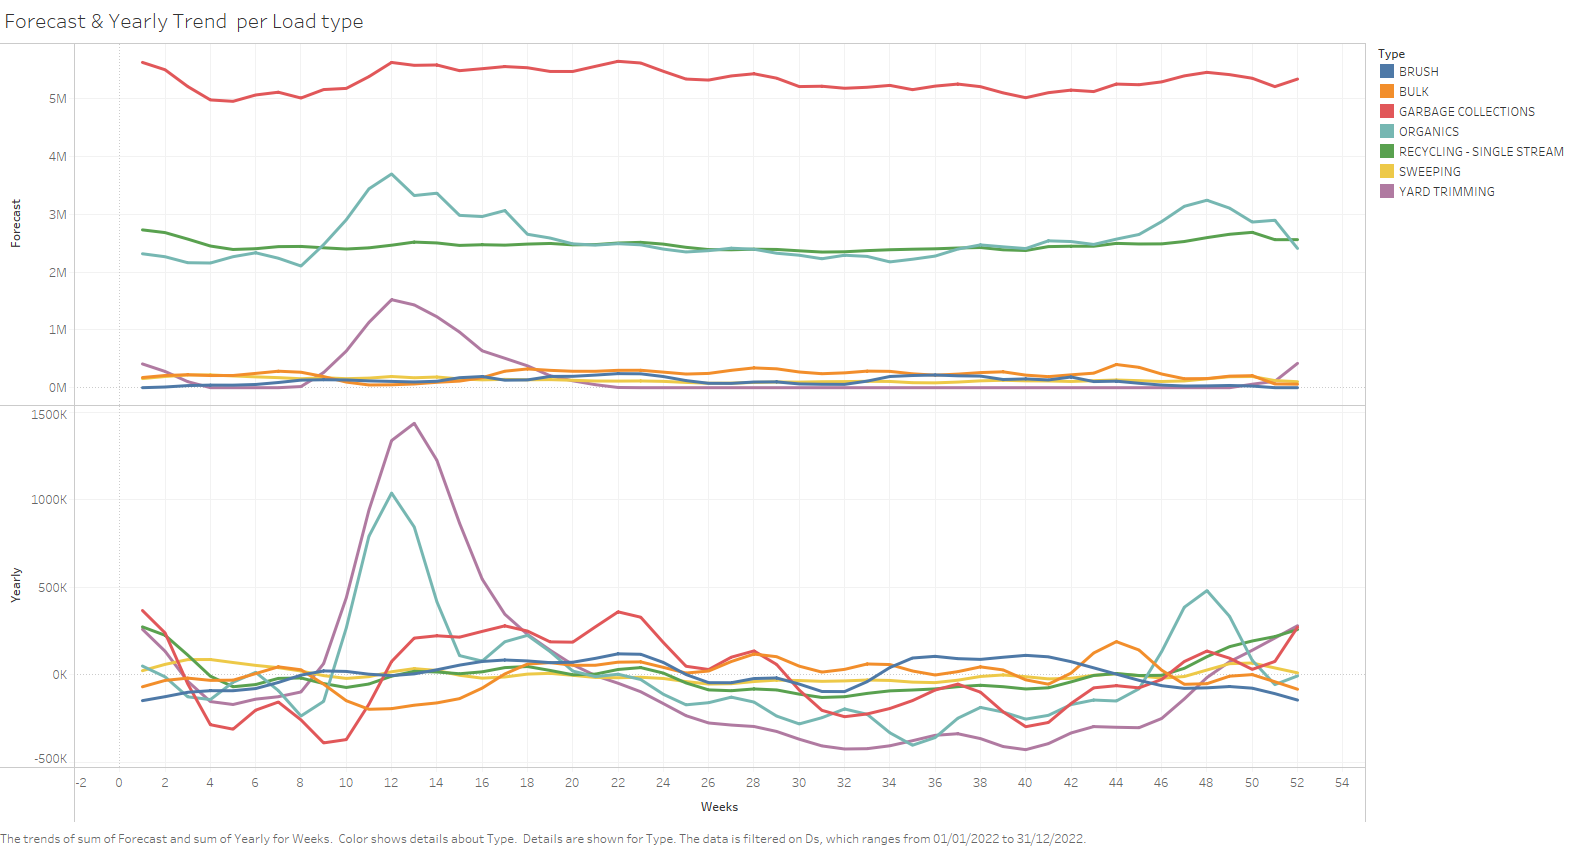

We get a new insight from the above graph that apart from the events which usually contribute to increase in organic waste due to lot of street food stalls, Yard trimmings have a peak in the end of March. It seems that the local authorities allocate the leftover budget for the financial year, which typically ends in March, into Yard Trimmings. Thus if this assumption is right, our model can also help them plan such activities in future.

### Observation
Lets have a look at the linear trend of solid waste and compare it with the Income of people in Austin.
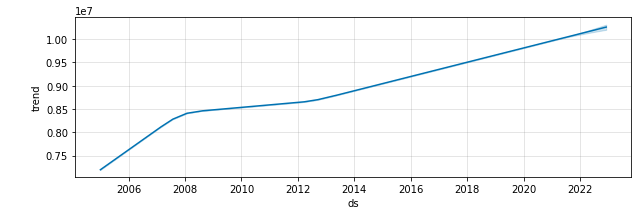

Compare the above with the below chart:
Trends in Austin, TX Real Median Household Income since 2005
At $80,954, the median household income for Austin was at a new inflation adjusted high in 2019.

Real Median Household Income: Austin (in Blue), Texas (in black), National (in grey)

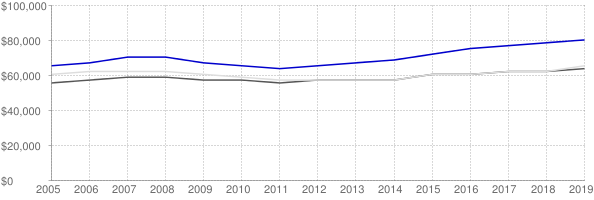

A simple comparision shows that during the years 2008 to 2012 the rate of solid waste generation was the least and this was also the same time period in which "Real Median Household Income" in Austin saw a decrease.

This was probably due to the recession and the economy not doing so well in these years. In other years when the economy performed well, a lot of waste was generated. Therefore a booming economy, though good for people is not great for solid waste generation. We must therefore favour businesses which are concious about the waste they generate. New businesses such as https://zerowasteonlineshop.com/ must be encouraged.

### Applications & Impact

#### Events - Preparation & Awareness programs
Our model identifies that some events contribute to increasing solid waste generation in Austin, specially the SXSW event. Our model can predict the amount of waste generated in such events in the future and thus the waste collection authorities can be ready for it.

#### Optimization of Waste collection trips
From our explorative analysis we see that the number of trips made by waste collection trucks has the potential to be reduced drastically. For this purpose, the forecasting model can be used to estimate when the load weight reaches a threshold and such information can be used to plan the sending out of trucks for waste collection.

#### Financial planning for Austin authorities
If our speculation is correct from the data that Yard Trimmings peak in March becasue the leftover budget for the year is used for this purpose then we think our model can help better financial planning.

#### Supporting a new environment concious businesses
Our analysis helps the government and people of Austin realize that our economic system and businesses in it can pose a threat to our environment and our future if we do not keep them in check. Our analysis supports new movements around sustainable businesses.



## 🖼️ Visualisations


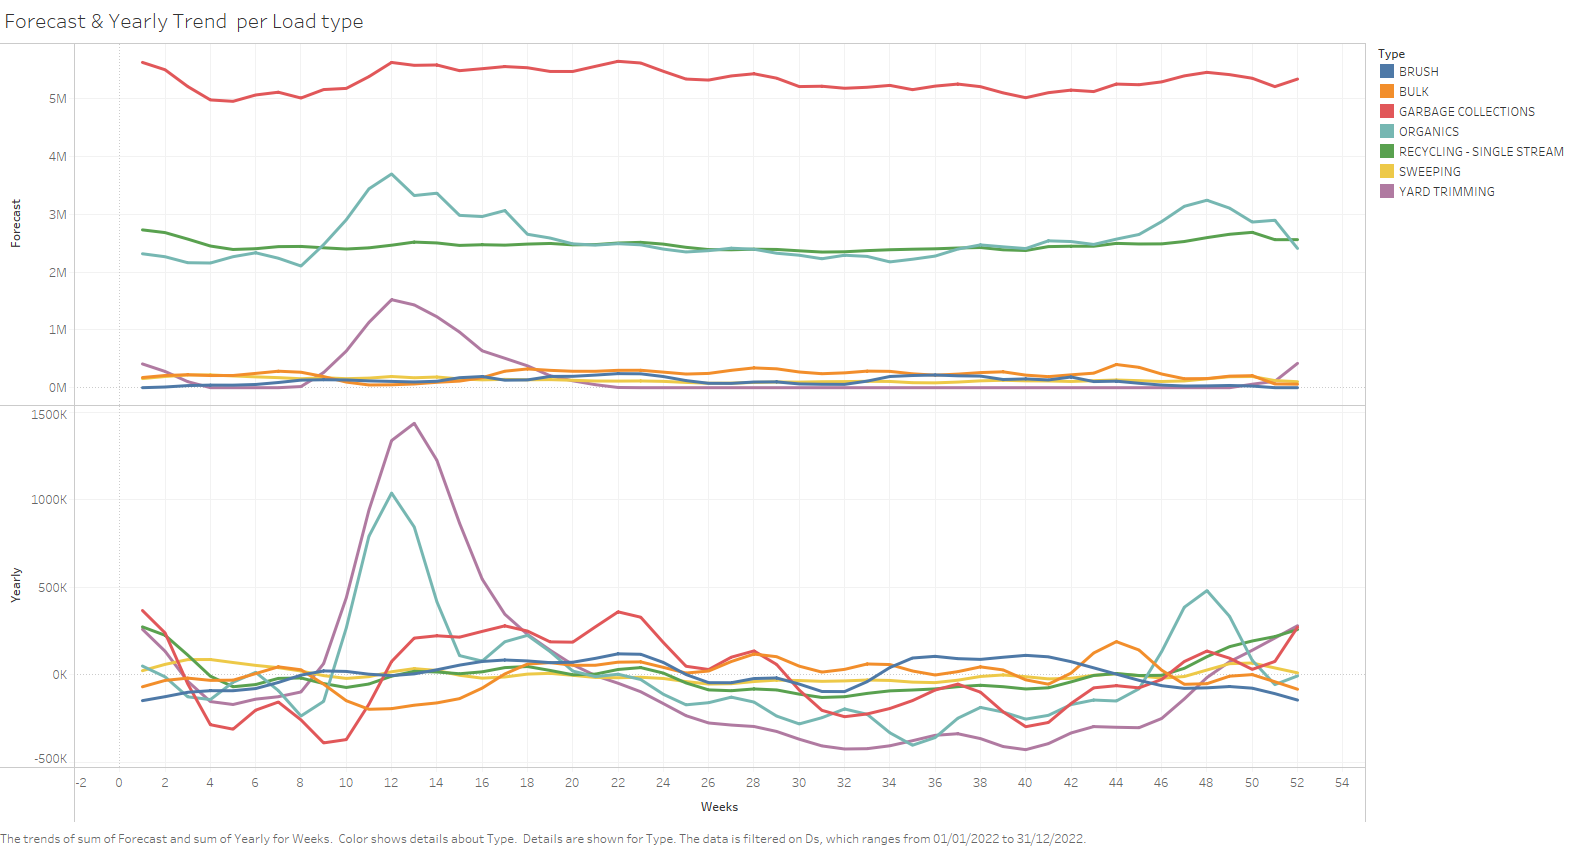

### Dashboard for EDA of Waste collection data
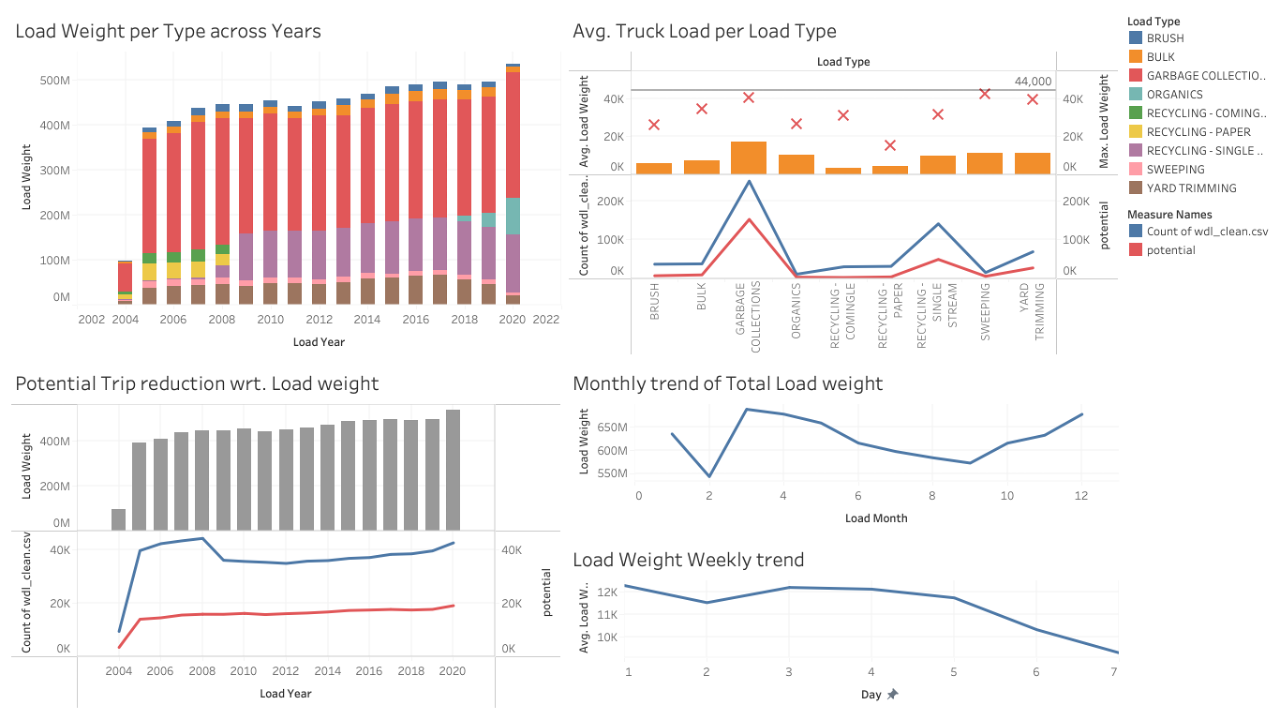

#### `Load Weight per Type across years`:
- This plot shows that Garbage collection consitutes the highest volume of generated waste and the overall trend is an increasing one

#### `Avg Load per Load Type` 
- The bar plot shows the average load weight for different load types. The red crosses show the maximum load weight for that type. It is assumed that an average waste collection truck has a max cap. of 44k lbs. The blue line in the line plot shows the average number of trips made for a given load type.
- However it is observed that not every trip is optimal in the context of optimal truck load (Assumed to be 80% of max. cap.) utilization. In case this optimality is achieved, which is shown by the red line in the plot, the gap between the red and the blue line then shows the  optimization potential per Load Type for the number of trips.

#### `Potential Trip reduction wrt. Load weight`
- This plot shows the optimization potential obtained by main utilizing full truck cap. and reducing the number of trips, across all years

#### `Monthly Trend of Total Load weight`
- The trend shows a peak in March which can be attributed to the SXSW festival which happens in mid March. This led us to investigate the other peaks and attribute them to other events that occur in Austin on a yearly basis.

#### `Load Weight weekly trend`
- The trend shows high volumes on weekdays, and a dip on the weekends.

## 👓 References

1.   Prophet documentation (https://facebook.github.io/prophet/docs/quick_start.html)
2.   Events in Austin (https://aquilacommercial.com/learning-center/what-to-do-austin-tx-guide-festivals-events/)
3.   Austin Texas Household Income (https://www.deptofnumbers.com/income/texas/austin/) 
4.   Garbage collection Truck capacity (https://routereadytrucks.com/blogs/know-4-major-types-garbage-trucks/)

## ⏭️ Appendix